In [19]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from RotationCurveFit import GaussFit_signle
from binnedFit_utilities import *

sys.path.append(dir_KLens)
from tfCube2 import GalaxyImage, TFCube
from KLtool import *

import astropy.units as u
import astropy.constants as constants

In [20]:
###### set up parameters ######
pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.25

pars['aspect'] = 0.2
pars['half_light_radius'] = 0.5
pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 1.0

pars['norm'] = 0.0

pars['Resolution'] = 6000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=pars['g1'])
theta_obs = cal_theta_obs(e_int=eint_thy, g2=pars['g2'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

###### find flux_norm ######

flux_norm = find_flux_norm(pars, R=1.5)
print("flux_norm", flux_norm)

avgFlux_per_pix = avgFlux_in_R_per_pix(pars, flux_norm=flux_norm, R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)


2.9999999999999994e-16 erg / (cm2 nm s)
eobs_thy: 0.13636363636363635
slitAng_major_p: 21.008452488130185
slitAng_minor_p: 111.00845248813019
flux_norm 2082.515335083008
avgFlux_per_pix 1.0


In [21]:
###### spectra ######
line_species='Halpha'
TF = TFCube(pars=pars, line_species=line_species, flux_norm=flux_norm, sky_norm=1.)

modelSpec = TF.model2D(vcirc=TF.pars['vcirc'], sini=TF.pars['sini'], \
                       g1=TF.pars['g1'], g2=TF.pars['g2'], vscale=TF.pars['vscale'], \
                       v_0=TF.pars['v_0'], r_0=TF.pars['r_0'], slitAngles=TF.pars['slitAngles'])

In [4]:
spec = modelSpec[0]
lambda_emit = pars['linelist']['lambda'][pars['linelist']['species']==line_species][0]
lambdaGrid = TF.lambdaGrid
spaceGrid = TF.spaceGrid

par_fid = TF.pars

In [5]:
def get_velocityGrid(lambdaGrid, lambda_cen):
    zGrid = lambdaGrid/lambda_cen - 1.
    c_kms = 299792.458
    vGrid = zGrid*c_kms
    return vGrid

# Plot spectrum (velocity unit)

In [6]:
GaussFit = GaussFit_signle(spec2D=modelSpec[0], lambda_emit=lambda_emit, lambdaGrid=lambdaGrid, spaceGrid=spaceGrid)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(spec2D=modelSpec[0])
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

# get pixel edges
lambda_min = np.min(GaussFit.lambdaGrid)  ; lambda_MAX = np.max(GaussFit.lambdaGrid)
x_min = np.min(GaussFit.spaceGrid)        ; x_MAX = np.max(GaussFit.spaceGrid)

lambda_cen = lambda_emit*(1.+par_fid['redshift'])

vGrid = get_velocityGrid(lambdaGrid=lambdaGrid, lambda_cen=lambda_cen)

time cost in gaussFit_spec2D: 0.16895580291748047 (secs)


In [7]:
fitted_peakVelocity = get_velocityGrid(lambdaGrid=fitted_peakLambda, lambda_cen=lambda_cen)

In [8]:
fitted_lambda_up = fitted_peakLambda+fitted_sigma
fitted_lambda_lo = fitted_peakLambda-fitted_sigma

fitted_velocity_lo = get_velocityGrid(lambdaGrid=fitted_lambda_up, lambda_cen=lambda_cen) - fitted_peakVelocity
fitted_velocity_up = fitted_peakVelocity - get_velocityGrid(lambdaGrid=fitted_lambda_lo, lambda_cen=lambda_cen) 

fitted_velocity_error = np.vstack((fitted_velocity_lo, fitted_velocity_up))
fitted_velocity_error.shape

(2, 256)

Text(0, 0.5, 'velocity')

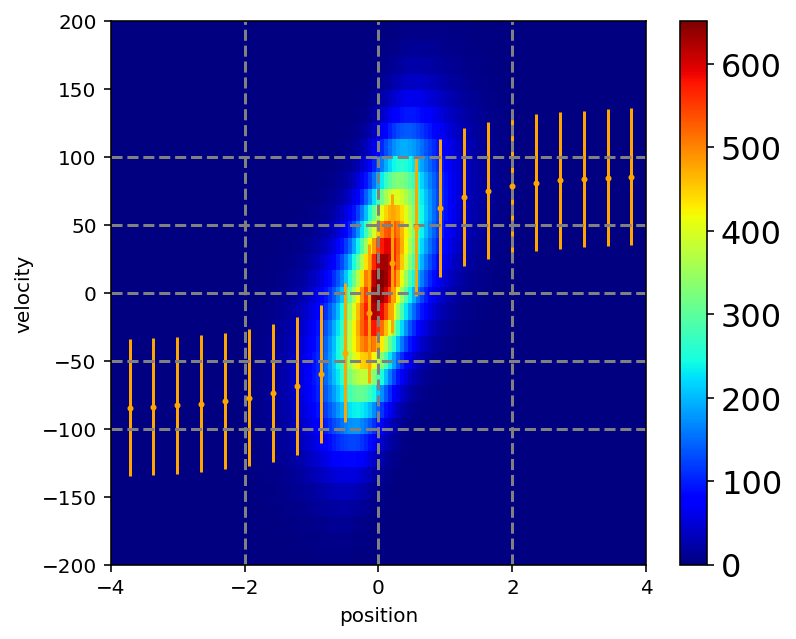

In [9]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,1,figsize=(6,5))
plt.rc('font',size=16)

POS, VEL = np.meshgrid(spaceGrid, vGrid)  # VEL, POS = np.meshgrid(grid_velocity, GaussFit.grid_pos)
img0=ax.pcolormesh(POS, VEL, spec.T, cmap='jet')          # img0 = ax.pcolormesh(POS, VEL, data, cmap='Greys')

#### gaussfit image peak identification summary (yellow)
ax.errorbar(GaussFit.spaceGrid[5::6], fitted_peakVelocity[5::6], yerr = fitted_velocity_error[:,5::6], color='orange', marker='o', markersize=2, ls='none', label='gauss1D fit on 2D spec')

ax.axhline(0., color='gray',ls='--')
ax.axhline(100., color='gray',ls='--')
ax.axhline(-100., color='gray',ls='--')
ax.axvline(0., color='gray',ls='--')
ax.axvline(2., color='gray',ls='--')
ax.axvline(-2., color='gray',ls='--')
ax.axhline(50., color='gray',ls='--')
ax.axhline(-50., color='gray',ls='--')

fig.colorbar(img0, ax=ax)
ax.set_xlim((-4, 4))
ax.set_ylim((-200., 200.))

ax.set_xlabel('position')
ax.set_ylabel('velocity')

# Plot spectrum (lambda unit)

In [17]:
spec2D = modelSpec[1]

GaussFit = GaussFit_signle(spec2D, lambda_emit, lambdaGrid, spaceGrid)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(spec2D)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = spec2D

# get pixel edges
lambda_min = np.min(GaussFit.lambdaGrid)  ; lambda_MAX = np.max(GaussFit.lambdaGrid)
x_min = np.min(GaussFit.spaceGrid)        ; x_MAX = np.max(GaussFit.spaceGrid)

time cost in gaussFit_spec2D: 0.2064378261566162 (secs)


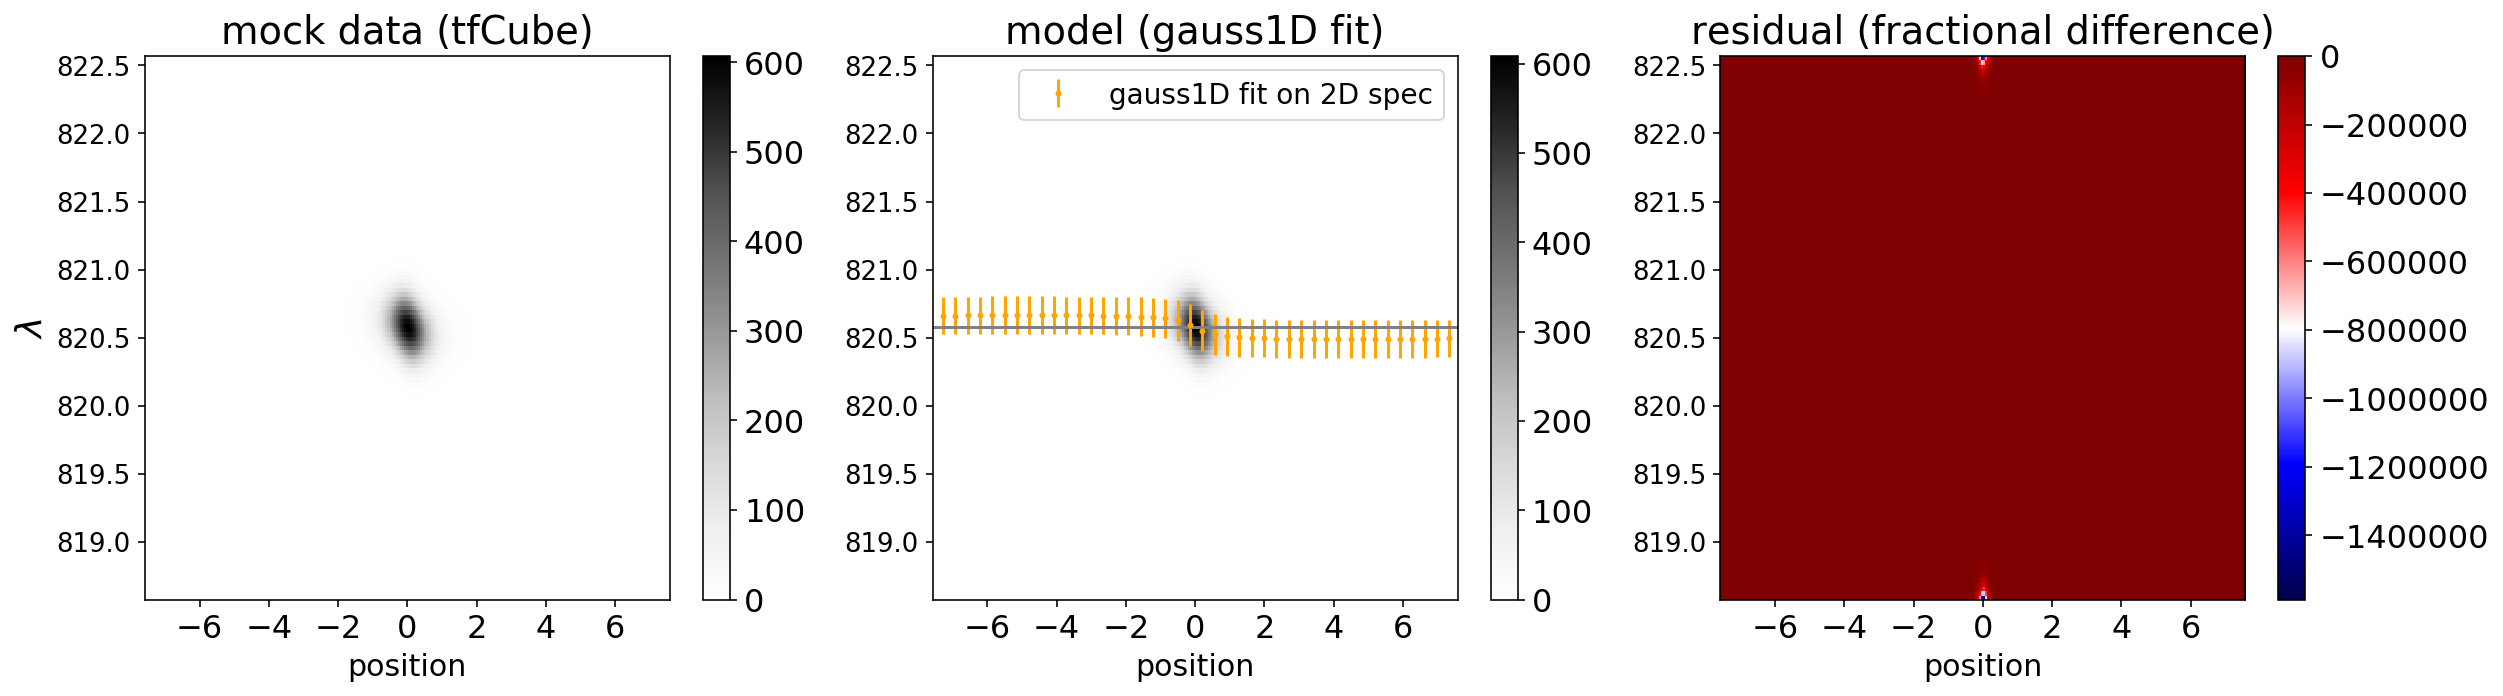

In [18]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])

#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(GaussFit.spaceGrid[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

In [22]:
np.pi/2.

1.5707963267948966

In [24]:
SG = np.flip(spaceGrid)
SG

array([ 7.584     ,  7.52451765,  7.46503529,  7.40555294,  7.34607059,
        7.28658824,  7.22710588,  7.16762353,  7.10814118,  7.04865882,
        6.98917647,  6.92969412,  6.87021176,  6.81072941,  6.75124706,
        6.69176471,  6.63228235,  6.5728    ,  6.51331765,  6.45383529,
        6.39435294,  6.33487059,  6.27538824,  6.21590588,  6.15642353,
        6.09694118,  6.03745882,  5.97797647,  5.91849412,  5.85901176,
        5.79952941,  5.74004706,  5.68056471,  5.62108235,  5.5616    ,
        5.50211765,  5.44263529,  5.38315294,  5.32367059,  5.26418824,
        5.20470588,  5.14522353,  5.08574118,  5.02625882,  4.96677647,
        4.90729412,  4.84781176,  4.78832941,  4.72884706,  4.66936471,
        4.60988235,  4.5504    ,  4.49091765,  4.43143529,  4.37195294,
        4.31247059,  4.25298824,  4.19350588,  4.13402353,  4.07454118,
        4.01505882,  3.95557647,  3.89609412,  3.83661176,  3.77712941,
        3.71764706,  3.65816471,  3.59868235,  3.5392    ,  3.47

In [25]:
spaceGrid

array([-7.584     , -7.52451765, -7.46503529, -7.40555294, -7.34607059,
       -7.28658824, -7.22710588, -7.16762353, -7.10814118, -7.04865882,
       -6.98917647, -6.92969412, -6.87021176, -6.81072941, -6.75124706,
       -6.69176471, -6.63228235, -6.5728    , -6.51331765, -6.45383529,
       -6.39435294, -6.33487059, -6.27538824, -6.21590588, -6.15642353,
       -6.09694118, -6.03745882, -5.97797647, -5.91849412, -5.85901176,
       -5.79952941, -5.74004706, -5.68056471, -5.62108235, -5.5616    ,
       -5.50211765, -5.44263529, -5.38315294, -5.32367059, -5.26418824,
       -5.20470588, -5.14522353, -5.08574118, -5.02625882, -4.96677647,
       -4.90729412, -4.84781176, -4.78832941, -4.72884706, -4.66936471,
       -4.60988235, -4.5504    , -4.49091765, -4.43143529, -4.37195294,
       -4.31247059, -4.25298824, -4.19350588, -4.13402353, -4.07454118,
       -4.01505882, -3.95557647, -3.89609412, -3.83661176, -3.77712941,
       -3.71764706, -3.65816471, -3.59868235, -3.5392    , -3.47